# **Projet 8 : Traitez les images pour le système embarqué d’une voiture autonome**

par Vincent Dujardin

## **Contexte**

**Future Vision Transport** est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes. 

Vous êtes l’un des ingénieurs IA au sein de l’équipe R&D de cette entreprise. Votre équipe est composée d’ingénieurs aux profils variés. Chacun des membres de l’équipe est spécialisé sur une des parties du système embarqué de vision par ordinateur. 

Voici les différentes parties du système :

1. acquisition des images en temps réel
2. traitement des images
3. **segmentation des images (c’est vous !)**
4. système de décision


## **Objectifs**

Votre rôle est de **concevoir un premier modèle de segmentation d’images** qui devra s’intégrer facilement dans la chaîne complète du système embarqué.

Lors d’une première phase de cadrage, vous avez récolté les avis de Franck et Laura, qui travaillent sur les parties avant et après votre intervention :

**Franck**, en charge du traitement des images (2) :
-  Le jeu de données que Franck utilise est disponible à ce lien, ou en téléchargement direct à ces liens : 1 ou 2, (images segmentées et annotées de caméras embarquées). On a uniquement besoin des 8 catégories principales (et non pas des 32 sous-catégories)

**Laura**, en charge du système de décision (4) :
-  Souhaite une API simple à utiliser.
-  L’API prend en entrée une image et renvoie la segmentation de l’image de l’algo.


## **Livrables**

Pour récapituler, vous avez dressé un plan d’action, avec les points suivants :

-  **entraîner un modèle de segmentation** des images sur les 8 catégories principales. **Keras** est le framework de travail commun à toute l’équipe. Attention aux contraintes de Franck !
-  concevoir une **API de prédiction (Flask ou FastAPI)** qui sera utilisée par Laura et la déployer sur le Cloud **(Azure, Heroku, PythonAnywhere ou toute autre solution)**. Cette API prend en entrée une image et renvoie le mask prédit (segments prédits de l’image).
-  concevoir une **application web (Flask, Streamlit) de présentation des résultats** et la déployer sur le Cloud **(Azure, Heroku, PythonAnywhere ou toute autre solution)**. Cette application sera l’interface pour tester l’API et afficher les images et masks.


---

## **SOMMAIRE**

A venir..

---

## **1. Importer les bibliothèques**

In [1]:
# Gestion des fichiers et des opérations système
import os
from pathlib import Path
import json

# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # Permet de visualiser les valeurs manquantes dans le dataset

# Affichage stylisé et outils interactifs pour Jupyter Notebook
from IPython.display import Markdown
import ace_tools_open as tools  # Outils pour afficher des DataFrames et autres visualisations interactives

# TensorFlow / Keras : Deep Learning
import tensorflow as tf
from tensorflow import keras

import cv2

In [2]:
# Vérification si TensorFlow a été compilé avec CUDA (support GPU)
if tf.test.is_built_with_cuda():
    print("TensorFlow a été compilé avec CUDA: OUI")  # Indique si TensorFlow a accès à CUDA
else:
    print("TensorFlow a été compilé avec CUDA: NON")   # Indique que l'exécution se fera uniquement sur CPU

# Affichage des GPUs disponibles pour TensorFlow
print("GPUs disponible:", tf.config.list_physical_devices('GPU'))  # Liste les GPU accessibles


TensorFlow a été compilé avec CUDA: OUI
GPUs disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Récupération de la liste des GPUs physiques disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Activer la croissance dynamique de la mémoire GPU (évite l'allocation complète)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Forcer l'utilisation du premier GPU détecté
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Vérification après activation
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"TensorFlow utilise maintenant le GPU : {logical_gpus[0].name}")
        print(f"{len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s) disponibles.")

    except RuntimeError as e:
        print("Erreur lors de la configuration du GPU :", e)

else:
    print("Aucun GPU détecté, TensorFlow utilisera le CPU.")


TensorFlow utilise maintenant le GPU : /device:GPU:0
1 Physical GPU(s), 1 Logical GPU(s) disponibles.


## **2. Analyse du jeu de données**

In [4]:
# Définir les chemins vers les datas
leftImg8bit_path = 'data/leftImg8bit/'
gtFine_path = 'data/gtFine/'

In [5]:
# Fonction pour afficher la structure d'un dossier et le nombre de fichiers dans chaque sous-dossier
def afficher_structure_dossier(chemin_dossier):
    print(f"\nStructure du dossier : {chemin_dossier}\n")
    total_fichiers = 0  # Compteur global
    
    for root, dirs, files in os.walk(chemin_dossier):
        # Calculer le niveau d'indentation
        niveau = root.replace(chemin_dossier, "").count(os.sep)
        indent = "│   " * niveau + "├── "

        # Afficher le dossier actuel
        print(f"{indent}{os.path.basename(root)} ({len(files)} fichiers)")

        # Compter le nombre total de fichiers
        total_fichiers += len(files)

    print(f"\nTotal des fichiers dans {chemin_dossier}: {total_fichiers}\n")


In [6]:
# Afficher la structure de leftImg8bit
afficher_structure_dossier(leftImg8bit_path)


Structure du dossier : data/leftImg8bit/

├──  (0 fichiers)
├── test (0 fichiers)
│   ├── berlin (544 fichiers)
│   ├── bielefeld (181 fichiers)
│   ├── bonn (46 fichiers)
│   ├── leverkusen (58 fichiers)
│   ├── mainz (298 fichiers)
│   ├── munich (398 fichiers)
├── train (0 fichiers)
│   ├── aachen (174 fichiers)
│   ├── bochum (96 fichiers)
│   ├── bremen (316 fichiers)
│   ├── cologne (154 fichiers)
│   ├── darmstadt (85 fichiers)
│   ├── dusseldorf (221 fichiers)
│   ├── erfurt (109 fichiers)
│   ├── hamburg (248 fichiers)
│   ├── hanover (196 fichiers)
│   ├── jena (119 fichiers)
│   ├── krefeld (99 fichiers)
│   ├── monchengladbach (94 fichiers)
│   ├── strasbourg (365 fichiers)
│   ├── stuttgart (196 fichiers)
│   ├── tubingen (144 fichiers)
│   ├── ulm (95 fichiers)
│   ├── weimar (142 fichiers)
│   ├── zurich (122 fichiers)
├── val (0 fichiers)
│   ├── frankfurt (267 fichiers)
│   ├── lindau (59 fichiers)
│   ├── munster (174 fichiers)

Total des fichiers dans data/leftImg8b

In [7]:
# Afficher la structure de gtFine
afficher_structure_dossier(gtFine_path)


Structure du dossier : data/gtFine/

├──  (0 fichiers)
├── test (0 fichiers)
│   ├── berlin (2176 fichiers)
│   ├── bielefeld (724 fichiers)
│   ├── bonn (184 fichiers)
│   ├── leverkusen (232 fichiers)
│   ├── mainz (1192 fichiers)
│   ├── munich (1592 fichiers)
├── train (0 fichiers)
│   ├── aachen (696 fichiers)
│   ├── bochum (384 fichiers)
│   ├── bremen (1264 fichiers)
│   ├── cologne (616 fichiers)
│   ├── darmstadt (340 fichiers)
│   ├── dusseldorf (884 fichiers)
│   ├── erfurt (436 fichiers)
│   ├── hamburg (992 fichiers)
│   ├── hanover (784 fichiers)
│   ├── jena (476 fichiers)
│   ├── krefeld (396 fichiers)
│   ├── monchengladbach (376 fichiers)
│   ├── strasbourg (1460 fichiers)
│   ├── stuttgart (784 fichiers)
│   ├── tubingen (576 fichiers)
│   ├── ulm (380 fichiers)
│   ├── weimar (568 fichiers)
│   ├── zurich (488 fichiers)
├── val (0 fichiers)
│   ├── frankfurt (1068 fichiers)
│   ├── lindau (236 fichiers)
│   ├── munster (696 fichiers)

Total des fichiers dans data/

**<u>Commentaire :</u>**

On remarque que les deux dossiers on la même structure, mais pas le même nombre de fichiers.

Chaque dossier contient 3 dossiers qui correspondent à une séparation du jeu de données : 
- **test** : jeu de test
- **train** : jeu d'entraînement
- **val** : jeu de validation

Et dans chacune des parties, il y a un dossier par ville.

In [8]:
# Définir les chemins des dossiers
paths = {
    "Train Images": "data/leftImg8bit/train/",
    "Train Masks": "data/gtFine/train/",
    "Validation Images": "data/leftImg8bit/val/",
    "Validation Masks": "data/gtFine/val/",
    "Test Images": "data/leftImg8bit/test/",
    "Test Masks": "data/gtFine/test/"
}

In [9]:
# Fonction pour compter les fichiers dans un dossier et ses sous-dossiers
def count_files(directory):
    total_files = sum(len(files) for _, _, files in os.walk(directory))
    return total_files

# Calculer et afficher le nombre d'images par dossier
file_counts = {name: count_files(path) for name, path in paths.items()}

# Affichage des résultats
df_file_counts = pd.DataFrame(list(file_counts.items()), columns=["Dossier", "Nombre d'images"])
print(df_file_counts)


             Dossier  Nombre d'images
0       Train Images             2975
1        Train Masks            11900
2  Validation Images              500
3   Validation Masks             2000
4        Test Images             1525
5         Test Masks             6100


In [10]:
# Vérifier les noms des images pour trouver un identifiant

# Fonction pour afficher un tableau structuré
def afficher_fichiers_structures(img_dir, mask_dir, n=5):
    # Récupérer les fichiers
    img_files = sorted(os.listdir(img_dir))[:n]
    mask_files = sorted(os.listdir(mask_dir))[:n*4]  # Il y a plusieurs masques par image

    # Structurer l'affichage
    print("\nFichiers dans", img_dir)
    print("-" * 50)
    for img in img_files:
        print(f"Image : {img}")

    print("\nFichiers dans", mask_dir)
    print("-" * 50)
    for mask in mask_files:
        print(f"Masque : {mask}")

# Exécuter sur un dossier exemple
afficher_fichiers_structures("data/leftImg8bit/train/aachen/", "data/gtFine/train/aachen/")



Fichiers dans data/leftImg8bit/train/aachen/
--------------------------------------------------
Image : aachen_000000_000019_leftImg8bit.png
Image : aachen_000001_000019_leftImg8bit.png
Image : aachen_000002_000019_leftImg8bit.png
Image : aachen_000003_000019_leftImg8bit.png
Image : aachen_000004_000019_leftImg8bit.png

Fichiers dans data/gtFine/train/aachen/
--------------------------------------------------
Masque : aachen_000000_000019_gtFine_color.png
Masque : aachen_000000_000019_gtFine_instanceIds.png
Masque : aachen_000000_000019_gtFine_labelIds.png
Masque : aachen_000000_000019_gtFine_polygons.json
Masque : aachen_000001_000019_gtFine_color.png
Masque : aachen_000001_000019_gtFine_instanceIds.png
Masque : aachen_000001_000019_gtFine_labelIds.png
Masque : aachen_000001_000019_gtFine_polygons.json
Masque : aachen_000002_000019_gtFine_color.png
Masque : aachen_000002_000019_gtFine_instanceIds.png
Masque : aachen_000002_000019_gtFine_labelIds.png
Masque : aachen_000002_000019_gtFi

In [11]:
# Fonction pour regrouper toutes les images et masques dans un DataFrame
def associer_images_masques(img_root, mask_root):
    data = []

    # Parcourir tous les sous-dossiers (train, val, test)
    for dataset_type in ["train", "val", "test"]:
        img_dir = os.path.join(img_root, dataset_type)
        mask_dir = os.path.join(mask_root, dataset_type)

        # Vérifier que les dossiers existent avant de continuer
        if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
            continue

        # Parcourir les sous-dossiers par ville
        for city in os.listdir(img_dir):
            city_img_path = os.path.join(img_dir, city)
            city_mask_path = os.path.join(mask_dir, city)

            # Vérifier si le sous-dossier contient des fichiers
            if not os.path.isdir(city_img_path):
                continue

            # Lister toutes les images dans le dossier ville
            img_files = sorted([f for f in os.listdir(city_img_path) if f.endswith(".png")])

            for img in img_files:
                base_name = img.replace("_leftImg8bit.png", "")  # Extraire l'identifiant principal
                
                # Construire les chemins des masques
                mask_color = f"{base_name}_gtFine_color.png"
                mask_instance = f"{base_name}_gtFine_instanceIds.png"
                mask_label = f"{base_name}_gtFine_labelIds.png"
                mask_polygons = f"{base_name}_gtFine_polygons.json"

                # Ajouter les données dans la liste
                data.append({
                    "Image": img,
                    "Dossier Image": city_img_path + "/",  # Ajouter "/" pour bien indiquer un dossier
                    "Mask Color": mask_color if os.path.exists(os.path.join(city_mask_path, mask_color)) else None,
                    "Mask InstanceIds": mask_instance if os.path.exists(os.path.join(city_mask_path, mask_instance)) else None,
                    "Mask LabelIds": mask_label if os.path.exists(os.path.join(city_mask_path, mask_label)) else None,
                    "Mask Polygons": mask_polygons if os.path.exists(os.path.join(city_mask_path, mask_polygons)) else None,
                    "Dossier Mask": city_mask_path + "/"  # Ajouter "/" pour bien indiquer un dossier
                })

    return pd.DataFrame(data)


In [12]:
# Exécuter la fonction
df_association = associer_images_masques(leftImg8bit_path, gtFine_path)

# Affichage du DataFrame
tools.display_dataframe_to_user(name="Association Images - Masques", dataframe=df_association)


Association Images - Masques


In [13]:
# Fonction pour afficher une image et ses masques associés (sans JSON)
def afficher_image_et_masks(image_index, df):
    # Récupérer les infos de l'image à l'index donné
    row = df.iloc[image_index]

    # Construire les chemins complets
    img_path = os.path.join(row["Dossier Image"], row["Image"])
    mask_color_path = os.path.join(row["Dossier Mask"], row["Mask Color"]) if row["Mask Color"] else None
    mask_instance_path = os.path.join(row["Dossier Mask"], row["Mask InstanceIds"]) if row["Mask InstanceIds"] else None
    mask_label_path = os.path.join(row["Dossier Mask"], row["Mask LabelIds"]) if row["Mask LabelIds"] else None

    # Charger les images si elles existent
    img = plt.imread(img_path) if os.path.exists(img_path) else None
    mask_color = plt.imread(mask_color_path) if mask_color_path and os.path.exists(mask_color_path) else None
    mask_instance = plt.imread(mask_instance_path) if mask_instance_path and os.path.exists(mask_instance_path) else None
    mask_label = plt.imread(mask_label_path) if mask_label_path and os.path.exists(mask_label_path) else None

    # Affichage du titre avec le nom de l'image
    print(f"\nAffichage des masques pour : {row['Image']}\n")

    # Création de la grille d'affichage
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    if img is not None:
        axes[0, 0].imshow(img)
        axes[0, 0].set_title("Image originale")
    else:
        axes[0, 0].set_title("Image non trouvée")

    if mask_color is not None:
        axes[0, 1].imshow(mask_color)
        axes[0, 1].set_title("Masque Color")

    if mask_instance is not None:
        axes[1, 0].imshow(mask_instance)
        axes[1, 0].set_title("Masque InstanceIds")

    if mask_label is not None:
        axes[1, 1].imshow(mask_label)
        axes[1, 1].set_title("Masque LabelIds")

    for ax in axes.flat:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [14]:
# Fonction pour afficher les annotations du fichier JSON
def afficher_annotations_json(image_index, df):
    # Récupérer les infos de l'image
    row = df.iloc[image_index]
    mask_polygons_path = os.path.join(row["Dossier Mask"], row["Mask Polygons"]) if row["Mask Polygons"] else None

    # Vérifier si le fichier JSON existe
    if not mask_polygons_path or not os.path.exists(mask_polygons_path):
        print(f"\nAucune annotation trouvée pour : {row['Image']}\n")
        return

    # Charger les annotations JSON
    with open(mask_polygons_path, "r") as f:
        polygons_data = json.load(f)

    # Affichage du tableau d'annotations
    print("\nObjets annotés dans polygons.json :")
    print("-" * 50)
    print(f"{'Label':<12} | {'Sommets':<8} | Extrait des coordonnées")
    print("-" * 50)

    for obj in polygons_data["objects"]:
        label = obj["label"]
        num_points = len(obj["polygon"])
        extrait = obj["polygon"][:3]  # Affiche les 3 premières coordonnées

        print(f"{label:<12} | {num_points:<8} | {extrait}")


Affichage des masques pour : aachen_000000_000019_leftImg8bit.png



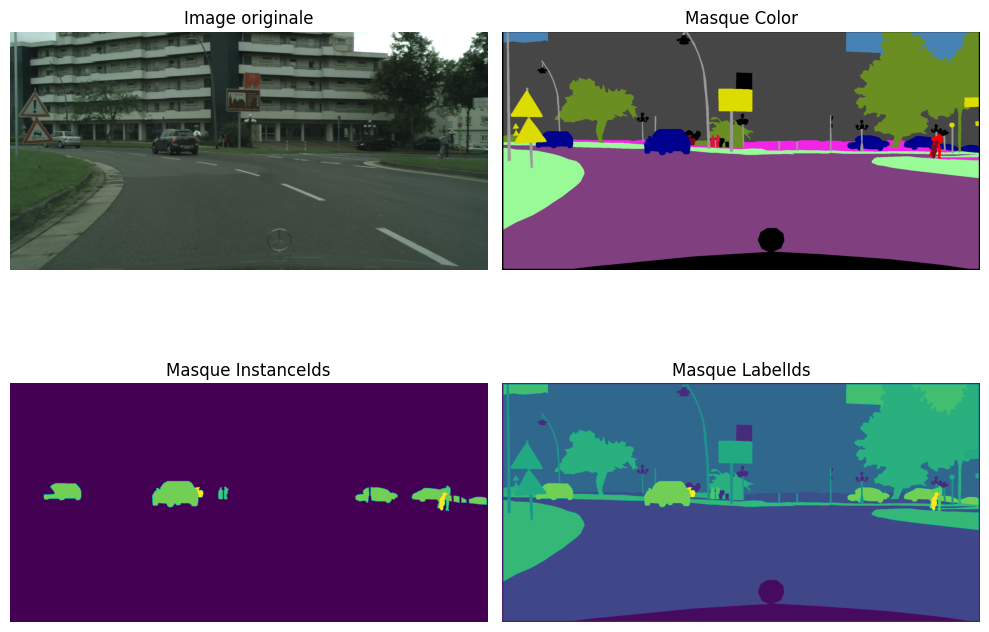

In [15]:
# Afficher la première image et ses masques
afficher_image_et_masks(0, df_association)

In [16]:
# Afficher les annotations JSON pour la même image
afficher_annotations_json(0, df_association)


Objets annotés dans polygons.json :
--------------------------------------------------
Label        | Sommets  | Extrait des coordonnées
--------------------------------------------------
road         | 23       | [[0, 769], [290, 574], [93, 528]]
sidewalk     | 6        | [[2047, 532], [1911, 537], [1828, 540]]
car          | 47       | [[806, 503], [803, 524], [796, 528]]
car          | 27       | [[281, 430], [196, 429], [181, 436]]
car          | 27       | [[281, 430], [196, 429], [181, 436]]
sky          | 4        | [[0, 89], [2047, 237], [2047, 0]]
terrain      | 36       | [[2047, 631], [1758, 598], [1671, 586]]
building     | 44       | [[696, 0], [1418, 0], [1448, 2]]
building     | 10       | [[2045, 195], [1797, 206], [1707, 306]]
car          | 20       | [[2047, 525], [2026, 525], [2021, 526]]
terrain      | 84       | [[1933, 511], [2014, 520], [2047, 522]]
terrain      | 23       | [[31, 502], [60, 508], [101, 509]]
sidewalk     | 121      | [[1881, 504], [1906, 510],

![Class Definitions](images/Class_definitions.png)


**<u>Commentaire :</u>**

Les masques `labelIds` contiennent plus de 30 classes, mais pour notre projet, nous devons réduire ces classes en 8 catégories principales :

-  void (fond et éléments non pertinents)
-  flat (routes, trottoirs, rails)
-  construction (bâtiments, murs, clôtures, tunnels)
-  object (panneaux, feux de signalisation, poteaux)
-  nature (arbres, végétation, terrain)
-  sky (ciel)
-  human (personnes, cyclistes)
-  vehicle (voitures, camions, bus, motos, vélos)

Nous allons donc mapper chaque `labelIds` vers sa catégorie principale pour simplifier les masques.

Nous prenons la **<a href="https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py">liste des classes officielles du dataset Cityscapes</a>** pour regrouper les classes qui appartiennent à la même catégorie.

#### **Correspondance des classes de segmentation**
- Ces informations sont tirées de la documentation officielle de Cityscapes. Les identifiants sont utilisés dans les fichiers `*_labelIds.png` pour représenter les classes de segmentation.

| **Classe (EN)**       | **Classe (FR)**       | **ID** | **TrainID** | **Catégorie**     | **CatID** | **HasInstances** | **IgnoreInEval** | **Couleur (RGB)** | **Couleur (description)**      |
|------------------------|-----------------------|--------|-------------|-------------------|-----------|------------------|------------------|-------------------|--------------------------------|
| unlabeled             | Non étiqueté         | 0      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| ego vehicle           | Véhicule propre      | 1      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| rectification border  | Bord rectifié        | 2      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| out of roi            | Hors région d'intérêt| 3      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| static                | Statique            | 4      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| dynamic               | Dynamique           | 5      | 255         | void              | 0         | False            | True             | (111, 74, 0)      | Marron foncé                   |
| ground                | Sol                 | 6      | 255         | void              | 0         | False            | True             | (81, 0, 81)       | Violet foncé                   |
| road                  | Route               | 7      | 0           | flat              | 1         | False            | False            | (128, 64, 128)    | Violet                         |
| sidewalk              | Trottoir            | 8      | 1           | flat              | 1         | False            | False            | (244, 35, 232)    | Rose                           |
| parking               | Parking             | 9      | 255         | flat              | 1         | False            | True             | (250, 170, 160)   | Rose pâle                      |
| rail track            | Rail                | 10     | 255         | flat              | 1         | False            | True             | (230, 150, 140)   | Rouge clair                    |
| building              | Bâtiment            | 11     | 2           | construction      | 2         | False            | False            | (70, 70, 70)      | Gris                           |
| wall                  | Mur                 | 12     | 3           | construction      | 2         | False            | False            | (102, 102, 156)   | Gris-bleu                      |
| fence                 | Clôture             | 13     | 4           | construction      | 2         | False            | False            | (190, 153, 153)   | Gris clair                     |
| guard rail            | Garde-corps         | 14     | 255         | construction      | 2         | False            | True             | (180, 165, 180)   | Mauve                          |
| bridge                | Pont                | 15     | 255         | construction      | 2         | False            | True             | (150, 100, 100)   | Marron                         |
| tunnel                | Tunnel              | 16     | 255         | construction      | 2         | False            | True             | (150, 120, 90)    | Beige                          |
| pole                  | Poteau              | 17     | 5           | object            | 3         | False            | False            | (153, 153, 153)   | Gris clair                     |
| polegroup             | Groupe de poteaux   | 18     | 255         | object            | 3         | False            | True             | (153, 153, 153)   | Gris clair                     |
| traffic light         | Feu de signalisation| 19     | 6           | object            | 3         | False            | False            | (250, 170, 30)    | Orange                         |
| traffic sign          | Panneau de signal.  | 20     | 7           | object            | 3         | False            | False            | (220, 220, 0)     | Jaune                          |
| vegetation            | Végétation          | 21     | 8           | nature            | 4         | False            | False            | (107, 142, 35)    | Vert foncé                     |
| terrain               | Terrain             | 22     | 9           | nature            | 4         | False            | False            | (152, 251, 152)   | Vert clair                     |
| sky                   | Ciel                | 23     | 10          | sky               | 5         | False            | False            | (70, 130, 180)    | Bleu ciel                      |
| person                | Personne            | 24     | 11          | human             | 6         | True             | False            | (220, 20, 60)     | Rouge                          |
| rider                 | Cycliste/Motard     | 25     | 12          | human             | 6         | True             | False            | (255, 0, 0)       | Rouge vif                      |
| car                   | Voiture             | 26     | 13          | vehicle           | 7         | True             | False            | (0, 0, 142)       | Bleu foncé                     |
| truck                 | Camion              | 27     | 14          | vehicle           | 7         | True             | False            | (0, 0, 70)        | Bleu très foncé                |
| bus                   | Bus                 | 28     | 15          | vehicle           | 7         | True             | False            | (0, 60, 100)      | Bleu-vert foncé                |
| caravan               | Caravane            | 29     | 255         | vehicle           | 7         | True             | True             | (0, 0, 90)        | Bleu nuit                      |
| trailer               | Remorque            | 30     | 255         | vehicle           | 7         | True             | True             | (0, 0, 110)       | Bleu acier                     |
| train                 | Train               | 31     | 16          | vehicle           | 7         | True             | False            | (0, 80, 100)      | Turquoise foncé                |
| motorcycle            | Moto                | 32     | 17          | vehicle           | 7         | True             | False            | (0, 0, 230)       | Bleu vif                       |
| bicycle               | Vélo                | 33     | 18          | vehicle           | 7         | True             | False            | (119, 11, 32)     | Rouge sombre                   |
| license plate         | Plaque d'immatric. | -1     | -1          | vehicle           | 7         | False            | True             | (0, 0, 142)       | Bleu foncé                     |

---


In [17]:
# Table de correspondance entre les ID originaux des masques et les 8 catégories principales

# Clé = `labelId` dans les masques actuels
# Valeur = ID correspondant à la nouvelle catégorie (0 à 7)

label_mapping = {
    # Catégorie "void" (éléments ignorés) -> ID = 0
    0: 0,   # Unlabeled
    1: 0,   # Ego Vehicle
    2: 0,   # Rectification Border
    3: 0,   # Out of ROI
    4: 0,   # Static
    5: 0,   # Dynamic
    6: 0,   # Ground

    # Catégorie "flat" (routes, trottoirs, rails) -> ID = 1
    7: 1,   # Road
    8: 1,   # Sidewalk
    9: 1,   # Parking
    10: 1,  # Rail Track

    # Catégorie "construction" (bâtiments, murs, clôtures, tunnels) -> ID = 2
    11: 2,  # Building
    12: 2,  # Wall
    13: 2,  # Fence
    14: 2,  # Guard Rail
    15: 2,  # Bridge
    16: 2,  # Tunnel

    # Catégorie "object" (feux, panneaux, poteaux) -> ID = 3
    17: 3,  # Pole
    18: 3,  # Polegroup
    19: 3,  # Traffic Light
    20: 3,  # Traffic Sign

    # Catégorie "nature" (végétation, terrain) -> ID = 4
    21: 4,  # Vegetation
    22: 4,  # Terrain

    # Catégorie "sky" (ciel) -> ID = 5
    23: 5,  # Sky

    # Catégorie "human" (personnes, cyclistes) -> ID = 6
    24: 6,  # Person
    25: 6,  # Rider

    # Catégorie "vehicle" (voitures, camions, motos...) -> ID = 7
    26: 7,  # Car
    27: 7,  # Truck
    28: 7,  # Bus
    29: 7,  # Caravan
    30: 7,  # Trailer
    31: 7,  # Train
    32: 7,  # Motorcycle
    33: 7,  # Bicycle
    -1: 7,  # License Plate
}


Fonction pour convertir un masque labelIds en masques simplifiés

Nous devons maintenant appliquer cette table de correspondance aux masques labelIds.
Cela signifie que chaque pixel d'un masque sera remplacé par l'ID de sa catégorie principale.

In [18]:
def convertir_labelids_en_categories(mask_path, label_mapping):
    """
    Charge un masque `labelIds` et applique la conversion vers les 8 catégories principales.

    - mask_path : chemin du masque labelIds à convertir
    - label_mapping : dictionnaire de correspondance labelId → catégorie principale

    Retourne un masque où chaque pixel est remplacé par l'ID de sa nouvelle catégorie (0-7).
    """
    if not os.path.exists(mask_path):
        return None

    # Charger le masque `labelIds`
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Garde les valeurs int originales

    # Appliquer la table de correspondance avec np.vectorize pour une conversion rapide
    mask_simplifie = np.vectorize(lambda x: label_mapping.get(x, 0))(mask)  # Par défaut : Void (0)

    return mask_simplifie

Vérification de la conversion des masques

Pour vérifier que tout fonctionne, affichons un masque avant/après la conversion.

In [19]:
def afficher_comparaison_mask(image_index, df, label_mapping):
    """
    Affiche l'image originale, le masque `labelIds` et son équivalent simplifié en 8 catégories.

    - image_index : index dans le DataFrame
    - df : DataFrame contenant les chemins des images et masques
    - label_mapping : dictionnaire de correspondance labelId → catégorie principale
    """
    row = df.iloc[image_index]

    # Chemins des fichiers
    img_path = os.path.join(row["Dossier Image"], row["Image"])
    mask_path = os.path.join(row["Dossier Mask"], row["Mask LabelIds"])

    # Charger l'image originale et les masques
    img = plt.imread(img_path) if os.path.exists(img_path) else None
    mask_original = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) if os.path.exists(mask_path) else None
    mask_simplifie = convertir_labelids_en_categories(mask_path, label_mapping) if mask_original is not None else None

    # Création de la figure avec 3 colonnes
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    # Image originale
    if img is not None:
        axes[0].imshow(img)
        axes[0].set_title("Image Originale")
    else:
        axes[0].set_title("Image non trouvée")

    # Masque original (labelIds)
    if mask_original is not None:
        axes[1].imshow(mask_original, cmap="jet")
        axes[1].set_title("Masque Original (labelIds)")

    # Masque simplifié (8 catégories)
    if mask_simplifie is not None:
        axes[2].imshow(mask_simplifie, cmap="jet")
        axes[2].set_title("Masque Simplifié (8 Catégories)")

    # Retirer les axes
    for ax in axes.flat:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation :
# afficher_comparaison_mask(0, df_association, label_mapping)

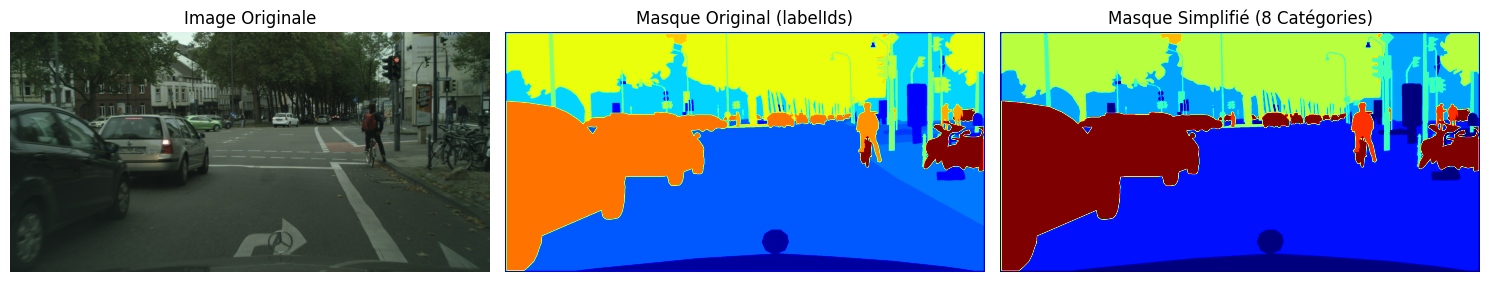

In [20]:
afficher_comparaison_mask(10, df_association, label_mapping)

## VGG16 Unet

In [21]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array


Data generator

In [22]:
class CityscapesDataset(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=16, image_size=(512, 256), augmentations=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.augmentations = augmentations

        # Récupérer toutes les images depuis les sous-dossiers
        self.image_files = []
        self.mask_files = []
        
        for city in os.listdir(image_dir):  # Parcourir les villes
            city_img_path = os.path.join(image_dir, city)
            city_mask_path = os.path.join(mask_dir, city)
            
            if not os.path.isdir(city_img_path):  # Vérifier que c'est un dossier
                continue
            
            # Trouver toutes les images et leurs masques correspondants
            img_files = sorted([f for f in os.listdir(city_img_path) if f.endswith(".png")])
            mask_files = sorted([f.replace("_leftImg8bit.png", "_gtFine_labelIds.png") for f in img_files])

            self.image_files.extend([os.path.join(city_img_path, f) for f in img_files])
            self.mask_files.extend([os.path.join(city_mask_path, f) for f in mask_files])

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []

        for img_path, mask_path in zip(batch_images, batch_masks):
            # Charger l'image et le masque
            image = load_img(img_path, target_size=self.image_size)
            image = img_to_array(image) / 255.0  # Normalisation

            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)

            # Convertir le mask en 8 classes
            mask_simplified = np.vectorize(lambda x: label_mapping.get(x, 0))(mask).astype(np.uint8)

            # S'assurer que le masque est toujours 2D
            if mask_simplified.ndim == 3:  
                mask_simplified = mask_simplified[:, :, 0]
            elif mask_simplified.ndim == 1:  
                mask_simplified = np.reshape(mask_simplified, self.image_size)

            # Ajouter une dimension pour compatibilité avec Keras
            mask_simplified = np.expand_dims(mask_simplified, axis=-1)

            images.append(image)
            masks.append(mask_simplified)

        return np.array(images), np.array(masks)

# Création des datasets avec les bons chemins
batch_size = 16
image_size = (512, 256)

train_dataset = CityscapesDataset(paths["Train Images"], paths["Train Masks"], batch_size=batch_size, image_size=image_size, augmentations=True)
val_dataset = CityscapesDataset(paths["Validation Images"], paths["Validation Masks"], batch_size=batch_size, image_size=image_size, augmentations=False)

print(f"Nombre d'images chargées : {len(train_dataset.image_files)}")
print(f"Nombre de masques chargés : {len(train_dataset.mask_files)}")


Nombre d'images chargées : 2975
Nombre de masques chargés : 2975


In [23]:
def appliquer_transformations(image, mask):
    """
    Applique différentes transformations à une image et son masque correspondant.
    Retourne : 
    - image originale
    - image inversée horizontalement
    - image zoomée légèrement
    - image légèrement pivotée (10°)
    """
    target_width, target_height = 512, 256  # Taille cible FIXE
    image = cv2.resize(image, (target_width, target_height))  # Assurer bon format
    mask = cv2.resize(mask, (target_width, target_height), interpolation=cv2.INTER_NEAREST)  # Masque en 2D

    # Transformation : Flip horizontal (gauche/droite)
    image_flipped = np.fliplr(image)
    mask_flipped = np.fliplr(mask)

    # Transformation : Zoom léger (1.1x) et recentrage
    zoom_factor = 1.1
    new_h, new_w = int(target_height * zoom_factor), int(target_width * zoom_factor)

    image_zoomed = cv2.resize(image, (new_w, new_h))
    mask_zoomed = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # Centrer et rogner au format original (512, 256)
    start_x = (new_w - target_width) // 2
    start_y = (new_h - target_height) // 2
    image_zoomed = image_zoomed[start_y:start_y + target_height, start_x:start_x + target_width]
    mask_zoomed = mask_zoomed[start_y:start_y + target_height, start_x:start_x + target_width]

    # Transformation : Rotation légère (10°)
    M = cv2.getRotationMatrix2D((target_width // 2, target_height // 2), 10, 1)
    image_rotated = cv2.warpAffine(image, M, (target_width, target_height), borderMode=cv2.BORDER_REFLECT)
    mask_rotated = cv2.warpAffine(mask, M, (target_width, target_height), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)

    return image, image_flipped, image_zoomed, image_rotated, mask, mask_flipped, mask_zoomed, mask_rotated


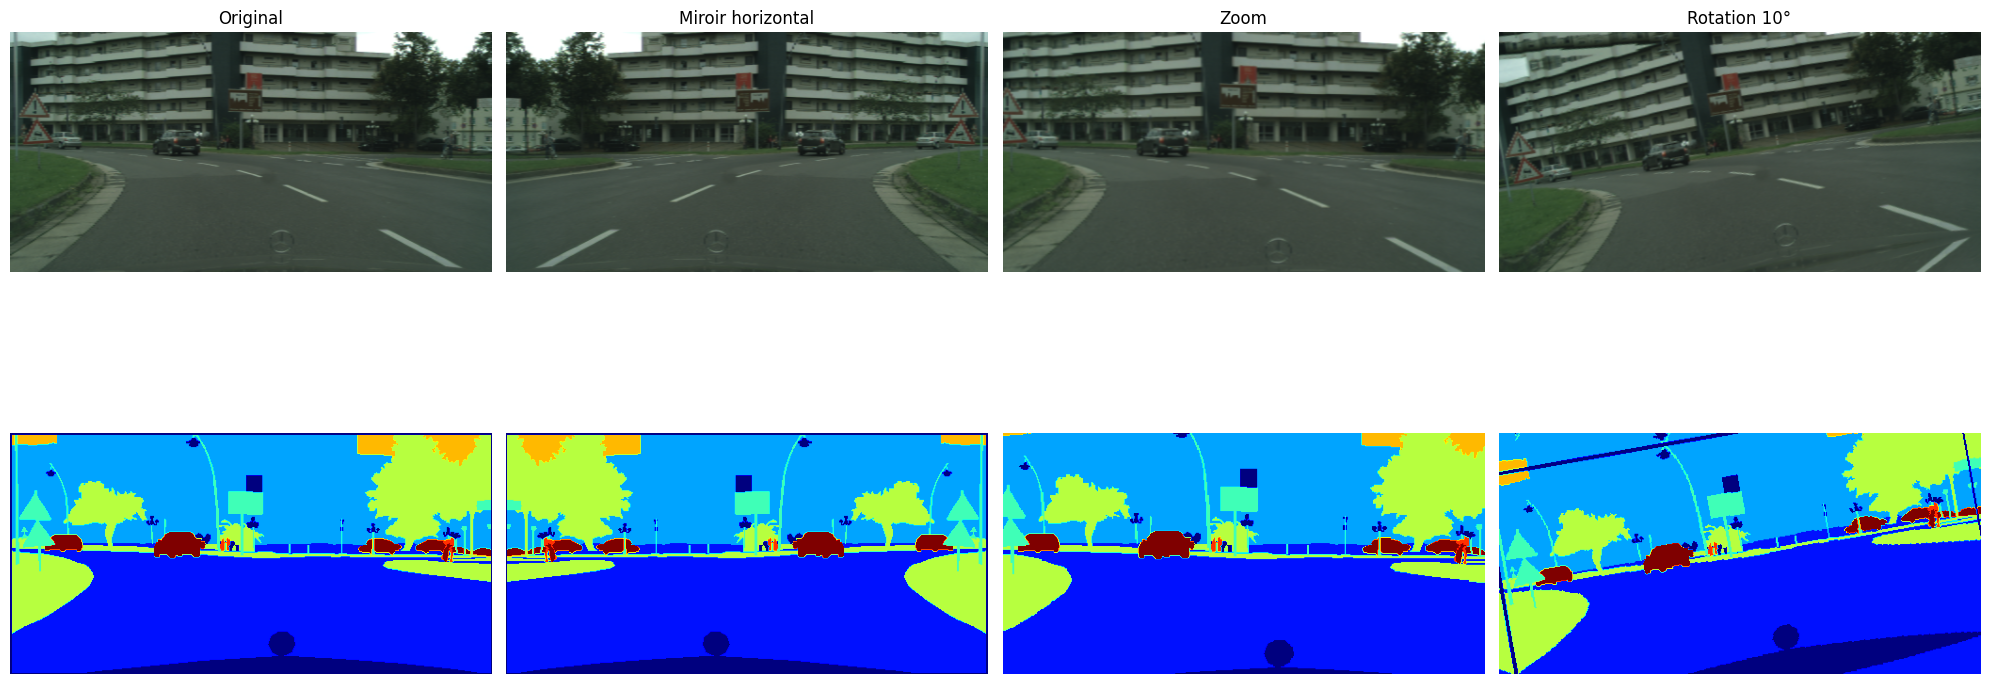

In [24]:
#Afficher les transformations
def afficher_transformations(dataset, image_index=0):
    """
    Affiche une image et ses transformations :
    - Originale
    - Miroir horizontal
    - Zoom
    - Rotation 10°
    
    Avec leurs masques correspondants.
    """
    img, mask = dataset[image_index]

    # Sélectionner la première image du batch
    img = img[0]
    mask = mask[0, :, :, 0] if mask.ndim == 4 else mask[0]

    # S'assurer que tout est bien en (512, 256)
    img = cv2.resize(img, (512, 256))
    mask = cv2.resize(mask, (512, 256), interpolation=cv2.INTER_NEAREST)

    # Appliquer les transformations
    images, img_flipped, img_zoomed, img_rotated, masks, mask_flipped, mask_zoomed, mask_rotated = appliquer_transformations(img, mask)

    # Définir le format de la figure (2 lignes, 4 colonnes)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    titles = ["Original", "Miroir horizontal", "Zoom", "Rotation 10°"]
    images_set = [images, img_flipped, img_zoomed, img_rotated]
    masks_set = [masks, mask_flipped, mask_zoomed, mask_rotated]

    # Affichage des images transformées
    for i in range(4):
        axes[0, i].imshow(images_set[i])
        axes[0, i].set_title(titles[i])
        axes[0, i].axis("off")

        axes[1, i].imshow(masks_set[i], cmap="jet")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# Vérification des transformations
afficher_transformations(train_dataset)
